This Jupyter notebook contains the GNNExplainer method.

In [2]:
import os

import pandas as pd
import networkx as nx
import numpy as np
import torch

import pickle
import copy

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from collections import Counter

In [27]:
dataset_nr = 1
assert dataset_nr == 1 or 2

embedding_method = 'e2v'
assert embedding_method == 'e2v' or 'm2v'

curr_working_dir = os.getcwd()
curr_output_dir = os.path.join(curr_working_dir, 'output')
dataset_output_dir = os.path.join(curr_output_dir, f'g{dataset_nr}_{embedding_method}')

if not os.path.exists(dataset_output_dir):
    os.mkdir(dataset_output_dir)
    print(f'Output folder for dataset {dataset_nr} is created: {dataset_output_dir}')
else:
    print(f'Output folder for dataset {dataset_nr} already exists and will be used: {dataset_output_dir}')
    
for item in os.listdir(dataset_output_dir):
    if os.path.isdir(item) and 'explanations' in item:
        print(item) # TODO: 
        
explanations_output_dir = os.path.join(dataset_output_dir, 'explanations')

if not os.path.exists(explanations_output_dir):
    os.mkdir(explanations_output_dir)
    print(f'Output folder for predictions from dataset {dataset_nr} is created: {explanations_output_dir}')
else:
    print(f'Output folder for predictions from dataset {dataset_nr} already exists and will be used: {explanations_output_dir}')

Output folder for dataset 1 already exists and will be used: c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v
Output folder for predictions from dataset 1 already exists and will be used: c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v\explanations


# Load all data

Load the nodes

In [4]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes

,index_id,id,semantic,label,semantic_id
0,0,WormBase:WBGene00000389,ORTH,cdc-25.4,5
1,1,ZP:0018675,DISO,right side lateral plate mesoderm mislocalised...,1
2,2,ZFIN:ZDB-GENE-040426-1197,ORTH,tbc1d5,5
3,3,5,DRUG,(S)-nicardipine,2
4,4,RGD:3443,ORTH,Ptk2,5
...,...,...,...,...,...
10029,10029,MP:0009763,DISO,increased sensitivity to induced morbidity/mor...,1
10030,10030,MP:0011057,DISO,absent brain ependyma motile cilia,1
10031,10031,MP:0001412,DISO,excessive scratching,1
10032,10032,WBPhenotype:0004023,DISO,frequency of body bend variant,1


In [5]:
nodes.iloc[5487]

index_id            5487
id             HGNC:6717
semantic            GENE
label              LTBP4
semantic_id            3
Name: 5487, dtype: object

In [6]:
node_labels_dict = nodes[['semantic_id', 'semantic']].drop_duplicates().set_index('semantic_id').to_dict()['semantic']
node_labels_dict

{5: 'ORTH',
 1: 'DISO',
 2: 'DRUG',
 4: 'GENO',
 7: 'VARI',
 3: 'GENE',
 0: 'ANAT',
 6: 'PHYS'}

Load the node embeddings

In [9]:
def loadEdge2VecEmbedding(): 
    node_feat = KeyedVectors.load(f'output/g{dataset_nr}_{embedding_method}/w2v_{dataset_nr}.dvectors', mmap='r')
    e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
    for idx, key in enumerate(node_feat.index_to_key):
        e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
        
    return e2v_embedding.sort_values('Node')

def loadMetapath2VecEmbedding():
    metapath2vec_embedding = pd.read_csv(f'output/g{dataset_nr}_{embedding_method}/metapath2vec_embedding_{dataset_nr}.csv')
    metapath2vec_embedding['Embedding'] = metapath2vec_embedding.values.tolist()
    metapath2vec_embedding = metapath2vec_embedding[['Embedding']]
    metapath2vec_embedding['Node'] = metapath2vec_embedding.index
    return metapath2vec_embedding[['Node', 'Embedding']]

In [10]:
if embedding_method == 'e2v':
    embedding = loadEdge2VecEmbedding()
else:
    embedding = loadMetapath2VecEmbedding()
    
embedding

,Node,Embedding
0,0,"[-0.51889515, -0.27600476, 1.4841187, -0.06068..."
1,1,"[-0.42672232, -0.5783169, 0.32593465, 0.221815..."
2,2,"[-0.6535885, -0.90137726, -0.032278683, 0.0108..."
3,3,"[-0.2691764, -0.69204295, 0.20973878, 0.102305..."
4,4,"[-0.5726995, -0.6201956, 0.31523106, 0.1010267..."
...,...,...
10029,10029,"[-0.3075929, -0.6312674, 0.18461354, 0.0889394..."
10030,10030,"[-0.30531076, -0.76736724, 0.2964231, 0.125141..."
10031,10031,"[-0.30683234, -0.7127532, 0.30363908, -0.10534..."
10032,10032,"[-0.5401776, -1.1480745, 0.67260635, 0.7167586..."


Load the edges

In [11]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0085464,CG34435,5,6825,0
1,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,HGNC:7585,MYL4,3,27,0
2,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0002772,Mlc1,5,8901,0
3,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,NCBIGene:396472,MYL4,3,9508,0
4,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in 1 to 1 orthology relationship with,ENSEMBL:ENSECAG00000020967,ENSEMBL:ENSECAG00000020967,5,8807,1
...,...,...,...,...,...,...,...,...,...,...
82908,4810,ibrutinib,2,1618,targets,HGNC:11283,SRC,3,3279,14
82909,522,carvedilol,2,184,targets,HGNC:620,APP,3,547,14
82910,OMIM:300377.0013,"DMD, EX18DEL",1,2822,is allele of,HGNC:2928,DMD,3,6612,16
82911,Coriell:GM05113,NIGMS-GM05113,4,8105,has role in modeling,MONDO:0010679,Duchenne muscular dystrophy,1,6315,15


Initialize a graph with edges and nodes including the embedding features of each node.

In [12]:
G = nx.Graph() # TODO: DiGraph?
for ind, node in embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([-0.5189, -0.2760,  1.4841, -0.0607, -0.0413, -0.1067,  0.0676, -0.0755,
         0.9547, -0.4007, -0.5608, -1.0221, -0.9254,  0.3233, -0.2541, -1.5503,
        -0.2603, -0.7199, -0.2066,  1.7181, -0.6343,  1.0000, -0.2462, -1.0636,
         1.5462, -0.9441,  0.0291,  0.5076,  0.1558, -0.8949,  0.3848, -0.7677])})
(0, 5765, {'edge_label': 'interacts with'})
Number of edges is 52024
Number of nodes is 10034


In [13]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
edge_labels_dict

{(0, 5765): 'interacts with',
 (0, 1681): 'in orthology relationship with',
 (0, 8615): 'in orthology relationship with',
 (0, 363): 'in orthology relationship with',
 (0, 5156): 'in orthology relationship with',
 (0, 8473): 'in orthology relationship with',
 (0, 6666): 'in orthology relationship with',
 (0, 5248): 'in 1 to 1 orthology relationship with',
 (0, 3961): 'in orthology relationship with',
 (0, 9835): 'in 1 to 1 orthology relationship with',
 (0, 2619): 'in orthology relationship with',
 (0, 8756): 'in orthology relationship with',
 (0, 1856): 'in orthology relationship with',
 (0, 3670): 'in 1 to 1 orthology relationship with',
 (0, 10028): 'in 1 to 1 orthology relationship with',
 (0, 6308): 'in orthology relationship with',
 (0, 2226): 'in orthology relationship with',
 (0, 8710): 'in orthology relationship with',
 (0, 5949): 'in orthology relationship with',
 (0, 2139): 'in orthology relationship with',
 (0, 9308): 'has phenotype',
 (0, 71): 'has phenotype',
 (1, 6012): 

Load trained model

In [15]:
from gnn.linkpred_model import LinkPredModel

with open(f'output/g{dataset_nr}_{embedding_method}/best_model_{dataset_nr}_{embedding_method}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(embedding['Embedding'][0]), 
                           loaded_args['hidden_dim'], loaded_args['output_dim'], 
                           loaded_args['layers'], loaded_args['aggr'], 
                           loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'output/g{dataset_nr}_{embedding_method}/best_model_{dataset_nr}_{embedding_method}.pth'))

<All keys matched successfully>

# Explain predictions

In [16]:
x = torch.Tensor(embedding['Embedding'])
print(x.shape)

torch.Size([10034, 32])


In [17]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)

torch.Size([2, 52024])


In [18]:
nx.is_directed(G)

False

In [19]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

num_hops = 1

def explain_edge(node_idx1, node_idx2):
    explainer = GNNExplainer(best_model,
                             epochs=700, num_hops=num_hops, lr=0.01)
    
    trigger = False
    early_stop = 0
    size = 15   # change size of the explanation graph
    iterations = 50 # number of times GNNExplainer is executed
    
    while not trigger:
        _, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2,
                                              x=x, edge_index=edge_index,
                                              G=G)
        
        G2 = copy.deepcopy(G)
        
        if size is not None:
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution threshold is', limit)
        else:
            limit = 0.5
        
        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])
        
        if nx.has_path(G2, node_idx1, node_idx2) and torch.is_nonzero(limit):
            trigger = True
            
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
        elif trigger: 
            print('Explanation found!')
            return edge_mask, limit
        
    return None, None
    

In [26]:
import ast

symptoms_drugs = pd.read_pickle(f'output/g{dataset_nr}_{embedding_method}/predictions/candidates_per_symptom_{dataset_nr}_{embedding_method}.pkl')
symptoms_drugs

,Symptom,Candidates
0,HP:0011675,"[231, 1576, 1937]"
1,HP:0002515,"[305, 332, 2173]"
2,HP:0003236,"[231, 305, 4318]"
3,HP:0002093,"[305, 332, 2173]"
4,HP:0003707,"[305, 2173, 332]"
5,HP:0001256,"[305, 2173, 332]"
6,HP:0003701,"[4225, 305, 332]"
7,HP:0003202,"[4225, 305, 332]"
8,HP:0003560,"[231, 624, 5359]"
9,HP:0003391,"[305, 332, 2173]"


In [18]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

found_explanation = []

for ind, edge in symptoms_drugs.iterrows(): 
    symptom_id = edge['Symptom']
    
    for drug_id in edge['Candidates']:
        node_idx1 = get_node_idx(symptom_id, nodes)
        print('node1:')
        print(nodes.loc[[node_idx1]])

        node_idx2 = get_node_idx(str(drug_id), nodes)
        print('node2:')
        print(nodes.loc[[node_idx2]])
        
        found_edge_mask, found_limit = explain_edge(node_idx1, node_idx2)
        
        if found_edge_mask is not None and found_limit is not None:
            found_explanation.append({'symptom': symptom_id, 'drug': drug_id, 'node_idx1': node_idx1, 'node_idx2': node_idx2, 'found_edge_mask': found_edge_mask, 'found_limit': found_limit})

node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.3567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 542.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 588.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 559.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 562.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 587.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 552.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 593.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 584.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 590.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 599.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 581.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 593.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 590.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 595.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 581.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 592.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 587.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 593.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 582.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 524.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 516.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 502.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 501.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 538.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 547.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 526.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 555.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 541.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 513.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 534.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 545.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 529.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 524.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 523.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 515.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 491.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 496.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 492.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 531.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 514.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 530.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 563.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 582.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 585.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 582.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 575.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 3776: 100%|██████████| 700/700 [00:01<00:00, 550.85it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id    id semantic        label  semantic_id
9011      9011  2612     drug  sapropterin            4
Prediction from trained model: tensor([0.7048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 567.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 570.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 569.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 562.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 571.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 542.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 567.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 556.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 562.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 569.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 563.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 555.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 568.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 515.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 551.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 560.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 572.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 564.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 579.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 574.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 588.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 582.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 571.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 564.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 571.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 569.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 586.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 556.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 567.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 569.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 575.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 540.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 574.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 579.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 533.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 515.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 533.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 560.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 562.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 579.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 559.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 567.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 518.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 577.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 559.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 564.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 559.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 579.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 567.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 9011: 100%|██████████| 700/700 [00:01<00:00, 561.81it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id    id semantic        label  semantic_id
7365      7365  4190     drug  ruxolitinib            4
Prediction from trained model: tensor([0.5228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 552.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 552.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 559.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 568.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 564.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 567.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 539.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 499.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 491.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 559.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 546.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 554.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 551.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 558.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 544.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 542.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 537.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 562.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 548.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 557.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 540.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 552.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 566.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 545.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 547.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 518.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 415.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 516.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 542.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 511.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 536.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 561.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 511.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 552.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 547.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 542.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 504.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 559.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 547.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 553.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 563.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 565.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 540.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 559.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 547.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 551.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 568.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 545.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 556.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7365: 100%|██████████| 700/700 [00:01<00:00, 566.79it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.3287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 588.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 545.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 568.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 587.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 617.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 595.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 566.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 613.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 570.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 581.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 589.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 591.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 583.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 604.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 592.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 598.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 597.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 600.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 587.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 582.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 592.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 577.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 572.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 531.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 581.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 579.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 589.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 593.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 597.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 588.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 598.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 593.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 593.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 579.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 593.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 574.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 584.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 575.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 590.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 589.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 589.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 595.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 585.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 597.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 595.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 527.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 564.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 575.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3697: 100%|██████████| 700/700 [00:01<00:00, 588.29it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.5021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 593.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 581.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 577.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 589.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 577.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 582.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 586.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 578.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 589.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 583.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 607.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 599.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 587.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 576.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 544.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 580.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 584.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 580.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 578.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 580.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 577.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 576.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 597.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 573.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 547.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 585.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 577.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 570.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 594.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 583.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 579.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 526.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 540.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 590.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 578.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 591.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 595.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 586.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 580.02it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id    id semantic        label  semantic_id
3956      3956  4483     drug  carfilzomib            4
Prediction from trained model: tensor([0.7337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 607.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 597.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 552.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 595.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 608.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 608.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 631.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 570.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 581.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 625.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 618.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 603.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 610.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 607.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 619.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 631.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 611.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 613.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 604.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 611.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 604.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 590.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 587.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 604.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 602.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 604.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 617.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 618.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.86it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id    id semantic        label  semantic_id
3956      3956  4483     drug  carfilzomib            4
Prediction from trained model: tensor([0.7457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 613.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 631.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 611.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 636.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 621.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 611.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 617.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 619.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 618.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 610.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 634.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 624.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 613.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 575.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 624.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 611.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 633.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 607.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 625.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 557.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 562.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 619.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 610.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 637.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 611.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 621.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 641.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 608.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 632.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3956: 100%|██████████| 700/700 [00:01<00:00, 610.09it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.7087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 621.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 599.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 607.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 588.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 633.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 622.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 593.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 620.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 570.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 631.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 608.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 594.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 597.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 594.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 600.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 580.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.72it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.3966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 613.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 608.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 632.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 592.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 580.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 579.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 621.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 620.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 623.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 635.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 612.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 614.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 626.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 615.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 630.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 627.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 588.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 604.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 631.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 591.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 605.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 630.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 620.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 613.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 618.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 634.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 607.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 543.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 591.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 627.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 627.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 606.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 625.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 612.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 614.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 616.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 596.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 628.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 634.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 630.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 620.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 620.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 619.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 616.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 633.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 619.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 631.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 633.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 595.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 592.26it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 475.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 540.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 545.22it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.64it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 578.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 545.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9070], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 562.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 555.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 548.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 571.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 571.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 569.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 573.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.31it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 548.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 523.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 540.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.22it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id    id semantic        label  semantic_id
3956      3956  4483     drug  carfilzomib            4
Prediction from trained model: tensor([0.8624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 566.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 532.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 576.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 563.88it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 574.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 570.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 567.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 558.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 566.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 560.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 573.03it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 562.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 559.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 557.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 561.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 576.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 557.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 546.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 576.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 554.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 557.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 582.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 575.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 560.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 577.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 575.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 564.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 573.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 570.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 565.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 550.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 570.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 573.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 572.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 562.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 565.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 564.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 558.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 564.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 518.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 571.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 526.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 570.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 561.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 564.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 573.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 564.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 569.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 574.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3956: 100%|██████████| 700/700 [00:01<00:00, 556.60it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.5490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 573.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 553.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 572.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 576.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 581.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 568.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 586.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 580.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 573.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 552.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.1640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 576.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 564.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 566.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 571.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 571.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 577.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 583.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 562.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 574.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 582.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 573.10it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.0511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 559.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 570.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 570.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 577.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 560.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 573.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 581.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 569.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 577.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 577.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 532.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 565.62it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.1963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 590.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 571.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 554.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 568.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 577.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 578.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.18it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.0075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 565.73it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 581.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 572.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 571.76it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 577.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 562.43it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 584.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 3776: 100%|██████████| 700/700 [00:01<00:00, 569.73it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 466.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 497.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 474.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 497.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 499.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 505.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 495.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 507.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 507.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 510.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 502.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 501.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 484.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 496.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 505.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 516.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 517.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 500.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 501.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 499.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 486.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 513.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 507.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 510.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 473.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 500.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.96it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 501.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 504.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 512.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 490.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 505.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 502.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 513.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 498.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 511.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 498.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 509.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 501.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 488.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 476.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 501.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 497.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 496.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 498.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 506.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 490.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 503.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 516.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 497.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 511.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 503.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 499.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 502.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 501.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 460.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 498.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 511.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 509.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 496.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 523.31it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id   id semantic         label  semantic_id
5542      5542  332     drug  benzthiazide            4
Prediction from trained model: tensor([0.9935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 514.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 488.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 510.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 517.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 512.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 513.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 499.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 515.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 513.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 519.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 492.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 515.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 511.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 509.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 512.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 509.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 493.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 508.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 517.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 503.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 504.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 517.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 514.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 499.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 512.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 509.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 509.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 506.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 515.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 510.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 511.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 493.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 505.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 507.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 488.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 506.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 494.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 507.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 506.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 499.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 513.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 509.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 507.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 512.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 482.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 475.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 505.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 511.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 517.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5542: 100%|██████████| 700/700 [00:01<00:00, 511.83it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.6596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 620.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 550.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 585.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 622.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 603.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8128], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 608.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 603.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 621.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 602.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 603.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 608.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 600.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 602.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 622.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 607.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 601.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 628.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 628.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 628.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 575.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.24it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 602.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 602.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 617.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 572.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 613.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 560.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 601.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 627.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 612.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 605.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 611.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 610.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 623.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 609.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 588.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 623.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 607.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 615.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 597.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 575.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 587.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 597.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 599.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 604.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 593.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 605.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 605.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 599.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 604.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 586.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 627.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 599.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 618.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 592.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 613.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 610.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 558.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 575.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 593.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 620.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 4998: 100%|██████████| 700/700 [00:01<00:00, 602.69it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.6866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 610.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 603.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 607.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 607.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 593.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 626.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 597.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 606.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 604.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 554.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 620.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 605.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 611.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 604.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 607.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 536.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 573.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 600.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 612.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 612.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 612.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 606.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 622.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 631.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 605.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 632.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 605.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 614.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 606.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 623.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 600.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 598.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 600.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 615.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 620.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 599.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 610.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 605.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 555.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 596.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 571.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 598.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 610.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 619.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 612.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 599.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 601.48it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic        label  semantic_id
3956      3956  4483     drug  carfilzomib            4
Prediction from trained model: tensor([0.9299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 642.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 599.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 632.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 623.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 630.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 633.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 649.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 624.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 642.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 546.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 618.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 636.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 576.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 635.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 617.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 648.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 632.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 624.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 636.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 634.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 642.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 625.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 636.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 639.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 631.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 646.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 632.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 630.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 644.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 638.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 593.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 621.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 642.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 619.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 646.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 628.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 621.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 636.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 3956: 100%|██████████| 700/700 [00:01<00:00, 634.63it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.5077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 637.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 643.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 640.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 618.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 630.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 632.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 636.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 633.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 574.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 594.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 618.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 637.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 641.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 627.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 639.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 630.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 643.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 640.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 631.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 609.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 637.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 626.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 634.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 634.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 633.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 639.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 626.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 627.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 588.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 587.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 633.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 598.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 632.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 643.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 627.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 631.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 633.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 637.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 633.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 651.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 633.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4998: 100%|██████████| 700/700 [00:01<00:00, 634.30it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 589.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 634.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 645.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 639.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 591.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 648.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 631.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 577.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 634.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 638.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 631.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 620.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 593.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 651.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 645.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 634.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 638.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 636.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 631.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 585.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 639.18it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 476.96it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 486.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 475.25it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id    id semantic      label  semantic_id
1651      1651  2173     drug  pinacidil            4
Prediction from trained model: tensor([0.5449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 465.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 477.32it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 485.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 476.48it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.3089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 497.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 462.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 470.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 465.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 470.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 482.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 466.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 479.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 473.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 489.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 472.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 475.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 485.66it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 481.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 485.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 484.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 454.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 453.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 485.71it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 479.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 483.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 488.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 480.89it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 474.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 482.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 481.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 484.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 481.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 486.88it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 473.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 476.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 480.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 478.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 477.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 475.25it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.1821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 480.31it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 486.30it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 451.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 459.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 476.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 485.97it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 492.37it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 478.40it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 467.03it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 488.94it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 1651: 100%|██████████| 700/700 [00:01<00:00, 484.43it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id   id semantic         label  semantic_id
5542      5542  332     drug  benzthiazide            4
Prediction from trained model: tensor([0.9932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 484.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 483.92it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 485.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 484.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 475.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 478.85it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 477.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 479.97it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 484.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 485.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 467.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 478.78it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 472.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 473.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 477.10it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 488.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 486.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 489.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 488.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 479.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 488.65it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 484.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 461.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 480.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 485.11it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 461.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 482.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 465.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 481.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 478.60it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 475.43it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 490.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 447.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 457.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 480.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 487.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 488.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 484.58it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 488.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 481.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 487.13it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 459.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 486.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 487.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 487.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 486.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 491.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 487.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 489.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 5542: 100%|██████████| 700/700 [00:01<00:00, 483.90it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id   id semantic         label  semantic_id
5542      5542  332     drug  benzthiazide            4
Prediction from trained model: tensor([0.9833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 646.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 627.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 642.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 618.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 608.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 608.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 615.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 644.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 646.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 647.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 646.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 645.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 636.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 640.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 655.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 639.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 647.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 656.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 631.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 643.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 640.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 647.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 639.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 640.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 636.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 642.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 619.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 550.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 566.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 614.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 646.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 640.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 627.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 657.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 637.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 620.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 639.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 645.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 641.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 649.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 643.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 640.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 645.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 653.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 643.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 646.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 647.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 644.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 645.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5542: 100%|██████████| 700/700 [00:01<00:00, 625.85it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id   id semantic                label  semantic_id
5883      5883  305     drug  bendroflumethiazide            4
Prediction from trained model: tensor([0.0064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 607.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 532.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 646.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 630.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 650.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 640.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 624.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 637.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 655.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 651.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 614.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 644.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 644.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 647.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 633.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 653.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 634.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 648.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 646.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 642.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 626.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 614.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 605.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 607.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 529.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 615.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 636.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 618.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 646.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 643.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 646.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 649.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 638.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 630.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 648.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 651.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 633.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 643.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 647.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 655.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 647.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 606.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 648.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 648.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 618.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 640.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 636.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 618.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 608.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5883: 100%|██████████| 700/700 [00:01<00:00, 623.05it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id    id semantic      label  semantic_id
1651      1651  2173     drug  pinacidil            4
Prediction from trained model: tensor([0.1456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 638.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 603.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 634.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 646.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 643.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 655.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 634.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 632.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 652.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 651.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 645.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 643.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 649.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 648.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 649.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 635.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 648.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 643.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 647.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 638.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 635.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 562.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 580.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 647.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 652.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 626.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 645.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 639.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 626.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 646.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 633.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 658.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 625.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 620.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 643.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 645.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 650.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 648.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 640.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 654.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 633.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 649.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 646.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 639.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 637.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 606.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 620.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 641.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 653.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 1651: 100%|██████████| 700/700 [00:01<00:00, 633.85it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.19it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 570.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 575.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 571.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 547.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 562.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 555.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 582.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 562.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 562.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 552.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 575.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 499.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 521.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 550.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 575.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 554.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 545.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 476.91it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.7721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 521.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 553.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 550.18it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 564.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 560.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 570.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 553.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 573.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 558.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 566.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 574.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 497.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 506.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 573.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 570.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 561.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 568.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 566.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 563.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 567.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 566.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 565.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 557.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 567.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 562.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 545.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 566.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 574.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 562.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 558.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 560.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 568.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 565.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 517.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 539.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 562.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 520.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 580.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 578.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 572.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 551.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 568.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 563.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 542.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 563.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 565.48it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 562.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 557.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 566.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 4998: 100%|██████████| 700/700 [00:01<00:00, 552.86it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.7647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 5262: 100%|██████████| 700/700 [00:01<00:00, 566.58it/s]


Contribution threshold is tensor(0.9936)
Explanation found!
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 531.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 539.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 530.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 521.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 524.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 531.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 528.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 537.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 542.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 534.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 535.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 524.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 522.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 525.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 530.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 525.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 525.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 469.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 516.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 522.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 530.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 523.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 525.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 534.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 530.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 530.18it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 530.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 528.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 519.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 526.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 430.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 523.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 531.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 519.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 533.47it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 531.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 500.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 544.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 544.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 531.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 523.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 537.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 526.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 529.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 528.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 529.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 528.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 514.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 488.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 529.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 523.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 523.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.80it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.8329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 515.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 532.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 527.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 533.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 531.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 528.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 532.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 530.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 522.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 502.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 509.51it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 593.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 627.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 622.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 631.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 626.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 605.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 624.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 622.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 617.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 624.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 633.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 630.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 626.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9712], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 603.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 624.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 587.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 603.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 616.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 595.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 623.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 622.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 599.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 629.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 612.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 618.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 616.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 625.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 609.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 616.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 616.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 607.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 631.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 622.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 581.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 625.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 617.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 556.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 571.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 615.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:01<00:00, 607.35it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 621.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 620.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 590.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 615.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 628.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 620.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 615.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 629.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 583.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 584.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 622.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 628.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 629.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 621.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 608.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 628.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 634.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 629.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 589.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 582.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 622.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.62it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id    id semantic        label  semantic_id
3956      3956  4483     drug  carfilzomib            4
Prediction from trained model: tensor([0.9106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 625.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 628.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 631.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 580.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 631.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 610.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 610.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 618.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 635.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 570.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 570.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 625.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 580.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 611.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 623.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 636.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 604.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 619.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 618.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 632.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 627.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 576.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2238], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 624.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 584.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 605.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 632.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 618.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 610.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 630.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 3956: 100%|██████████| 700/700 [00:01<00:00, 615.90it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.9851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 582.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 594.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 584.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 581.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 518.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 575.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 583.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 583.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 576.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 577.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 590.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 554.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 555.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 588.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 588.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 589.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 548.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 588.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 597.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 563.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 590.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 587.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 579.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 582.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 592.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 593.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 584.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 586.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 578.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 572.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 581.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 540.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 548.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 579.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 580.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 587.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 562.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 594.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 581.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 577.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 592.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 604.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 598.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 568.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 594.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 579.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.09it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id    id semantic        label  semantic_id
9663      9663  2774     drug  tropicamide            4
Prediction from trained model: tensor([0.4504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 573.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 577.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 572.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 575.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 572.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 573.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 572.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 551.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 536.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 572.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 567.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 584.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 579.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 579.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 571.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 587.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 582.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 575.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 574.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 569.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 575.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 574.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 566.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 586.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 563.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 570.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 566.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 577.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 573.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 570.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 563.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 575.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 584.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 581.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 578.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 529.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 577.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 593.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 571.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 572.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 566.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 552.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 577.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 575.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 578.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 578.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 576.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 575.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 582.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 9663: 100%|██████████| 700/700 [00:01<00:00, 566.56it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id    id semantic            label  semantic_id
4036      4036  2745     drug  trihexyphenidyl            4
Prediction from trained model: tensor([0.4744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 580.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 577.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 510.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 557.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 582.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 588.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 600.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 585.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 598.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 604.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 587.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 584.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 598.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 576.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 583.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 586.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 598.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 583.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 587.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 577.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 586.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 580.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 590.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 590.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 546.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 556.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 545.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 586.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 590.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 585.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 587.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 577.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 583.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 582.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 594.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 590.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 595.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 588.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 585.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 583.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 603.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 582.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 588.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 533.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 583.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 590.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 592.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 583.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 544.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4036: 100%|██████████| 700/700 [00:01<00:00, 569.75it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 562.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 541.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 554.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 555.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 555.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 518.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 552.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 551.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 551.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.02it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 562.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 551.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 552.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 555.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.94it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.9898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 555.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 550.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 555.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 562.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 559.20it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 569.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 566.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 554.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 540.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 564.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 559.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 565.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 564.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 538.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 547.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 554.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 552.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 575.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 548.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 566.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 555.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 558.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 555.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 559.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 555.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 563.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 540.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 574.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 577.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 561.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 570.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 570.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 557.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 562.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 545.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 571.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 528.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 554.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 563.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 565.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 569.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 563.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 549.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 562.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 564.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 561.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 558.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 582.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 569.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 3697: 100%|██████████| 700/700 [00:01<00:00, 537.08it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.5261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 5262: 100%|██████████| 700/700 [00:01<00:00, 567.46it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 490.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 505.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 462.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 505.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 502.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 499.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 484.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 514.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 510.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 492.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 507.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 496.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 505.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 464.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 482.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 495.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 507.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 509.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 509.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 509.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 517.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 519.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 482.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 510.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 513.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 510.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 513.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:01<00:00, 494.62it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 518.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 482.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 511.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 517.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 490.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 495.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 481.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 516.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 511.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 516.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 512.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 518.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 504.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 505.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 478.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 468.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 498.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 513.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 522.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 511.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 521.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 500.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 505.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 497.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 507.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 506.69it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 519.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 504.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 521.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 506.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 498.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 510.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 455.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 462.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 512.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 503.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 520.54it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 516.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 516.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 518.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.87it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id    id semantic        label  semantic_id
9011      9011  2612     drug  sapropterin            4
Prediction from trained model: tensor([0.8854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 511.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 507.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 510.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 485.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 510.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 500.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 497.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 518.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 493.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 505.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 509.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 470.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 477.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 515.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 509.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 513.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 505.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 521.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 511.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 511.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 507.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 514.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 509.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 514.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 485.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 496.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 511.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 501.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 506.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 479.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 509.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 515.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 472.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 516.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 507.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 508.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 497.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 518.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 502.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 482.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 518.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 520.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 506.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 517.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 505.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 512.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 516.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 511.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 512.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9011: 100%|██████████| 700/700 [00:01<00:00, 508.95it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
      index_id    id semantic    label  semantic_id
8921      8921  2966     drug  suramin            4
Prediction from trained model: tensor([0.0013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 523.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 512.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 515.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 459.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 499.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 520.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 518.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 517.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 519.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 514.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 524.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 520.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 525.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 507.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 524.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 503.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 518.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 526.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 530.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 530.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 524.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 523.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 520.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 522.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 504.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 506.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 510.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 528.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 517.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 530.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 497.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 512.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 512.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 524.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 515.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 523.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 510.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 524.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 519.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 513.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 518.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 506.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 520.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 508.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 514.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 484.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 488.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 519.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 492.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 8921: 100%|██████████| 700/700 [00:01<00:00, 523.20it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.9372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 516.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 507.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 512.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 521.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 523.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 519.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 516.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 500.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 520.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 521.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 517.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 530.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 524.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 523.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 482.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 473.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 517.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 521.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 490.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 520.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 525.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 524.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 514.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 521.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 522.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 507.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 494.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 513.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 526.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 511.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 515.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 499.76it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 490.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 496.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 514.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 515.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 521.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 535.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 511.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 522.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 524.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 516.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 514.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 3776: 100%|██████████| 700/700 [00:01<00:00, 528.45it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
      index_id    id semantic         label  semantic_id
2420      2420  1906     drug  nicotinamide            4
Prediction from trained model: tensor([0.3164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 493.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 523.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 519.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 525.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 521.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 493.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 516.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 518.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 516.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 486.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 518.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 520.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 521.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 523.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 525.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 523.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 507.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 504.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 504.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 513.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 522.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 512.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 508.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 494.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 529.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 507.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 523.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 516.72it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 524.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 513.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0128], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 487.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 508.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 520.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 510.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 517.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 514.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 531.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 523.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 520.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 515.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 527.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 530.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 513.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 516.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 518.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 516.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 531.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1712], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 518.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 518.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 2420: 100%|██████████| 700/700 [00:01<00:00, 519.36it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.6711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5262: 100%|██████████| 700/700 [00:01<00:00, 521.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5262: 100%|██████████| 700/700 [00:01<00:00, 481.36it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.7773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 2882: 100%|██████████| 700/700 [00:01<00:00, 503.08it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.6100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 544.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.43it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 516.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 528.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 502.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 521.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 516.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 514.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 518.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 478.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 497.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 507.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 509.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 526.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 512.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 519.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 490.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 513.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 518.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 513.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 518.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 501.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 519.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 526.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 465.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 497.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 495.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 514.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 516.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 529.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 518.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.84it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.7524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 625.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 620.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 644.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 585.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 633.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 621.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 639.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 621.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 634.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 631.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 572.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 582.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 627.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 637.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 595.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 616.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 642.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 622.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 633.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 642.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 640.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 646.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 640.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 635.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 635.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 634.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 632.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 637.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 634.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 636.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 599.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 619.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 601.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 608.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 636.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 638.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 581.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 598.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 636.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 628.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 629.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:01<00:00, 654.84it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.9898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 638.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 636.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 607.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 637.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 632.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 619.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 632.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 633.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 630.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 587.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 604.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 633.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 637.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 630.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 629.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 621.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 625.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 633.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 625.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 584.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 634.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 635.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 625.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 636.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 632.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 628.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 637.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 638.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 615.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 640.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 635.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 592.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 583.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 623.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 636.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 633.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 616.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 635.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 628.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 621.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 619.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 637.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 590.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 644.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 596.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 640.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 636.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 626.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 638.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:01<00:00, 607.59it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.0706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 637.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 634.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 642.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 581.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 593.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 638.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 634.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 588.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 644.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 634.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 621.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 633.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 576.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 594.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 633.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 639.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 600.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 643.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 636.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 636.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 635.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 645.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 650.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.89it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id    id semantic      label  semantic_id
1651      1651  2173     drug  pinacidil            4
Prediction from trained model: tensor([0.9911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 540.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 518.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 491.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 523.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 548.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 542.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 557.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 534.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 552.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 563.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 548.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 543.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 516.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 549.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 544.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 548.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 517.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 552.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 547.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 556.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 542.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 550.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 549.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 562.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 522.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 544.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 542.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 533.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 543.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 550.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 533.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 553.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 553.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 545.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 536.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 554.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 542.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 548.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 505.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 550.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 547.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 553.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 539.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 548.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 541.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 515.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 512.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 552.00it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 554.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1651: 100%|██████████| 700/700 [00:01<00:00, 541.00it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id   id semantic         label  semantic_id
5542      5542  332     drug  benzthiazide            4
Prediction from trained model: tensor([0.5109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 522.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 541.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 553.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 550.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 547.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 538.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 552.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 552.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 549.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 544.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 560.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 558.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 555.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 548.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 540.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 536.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 545.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 502.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 533.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 535.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 557.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 551.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 555.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 538.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 552.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 519.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 561.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 551.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 556.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 547.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 544.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 544.36it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 549.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 554.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 542.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 557.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 540.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 550.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 514.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 521.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 550.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 554.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 541.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 561.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 547.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 554.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 548.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 547.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 542.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 5542: 100%|██████████| 700/700 [00:01<00:00, 543.81it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 547.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 531.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 541.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 489.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 522.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 548.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 545.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 523.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 545.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 543.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 518.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 383.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 541.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 502.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 522.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 505.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 9966: 100%|██████████| 700/700 [00:01<00:00, 510.98it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.8996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 604.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 605.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 618.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 555.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 553.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 618.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 642.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 623.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 619.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 615.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 603.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 622.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 614.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 616.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 625.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 614.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 625.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 625.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 638.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 612.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 617.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 614.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 623.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 631.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 585.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 604.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 569.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 565.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 617.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 616.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 633.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 613.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 616.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 610.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 634.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 625.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 607.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 621.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 620.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 627.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 619.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 613.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 628.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 631.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 574.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 618.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 624.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 617.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 622.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3697: 100%|██████████| 700/700 [00:01<00:00, 605.69it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id    id semantic    label  semantic_id
8921      8921  2966     drug  suramin            4
Prediction from trained model: tensor([0.1289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 593.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 626.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 601.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 621.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 627.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 616.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 615.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 625.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 620.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 636.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 606.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 618.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 638.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 605.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 631.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 614.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 606.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 601.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 619.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 603.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 629.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 627.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 569.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 573.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 636.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 623.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 624.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 597.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 618.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 626.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 635.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 579.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 634.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 615.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 615.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 594.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 625.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 618.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 625.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 623.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 622.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 581.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 629.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 621.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 608.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 618.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 598.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 610.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 609.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 8921: 100%|██████████| 700/700 [00:01<00:00, 625.22it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id    id semantic         label  semantic_id
2420      2420  1906     drug  nicotinamide            4
Prediction from trained model: tensor([0.9180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 602.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 600.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 626.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 629.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 612.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 611.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 628.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 633.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 624.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 620.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 609.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 630.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 603.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 581.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 621.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 611.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 579.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 596.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 623.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 536.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 584.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 636.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 624.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 629.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 629.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 609.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 616.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 628.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 616.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 620.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 622.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 610.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 629.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 624.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 625.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 610.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 622.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 599.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 625.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 617.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 617.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 572.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 604.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 588.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 626.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 616.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 622.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 610.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 610.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 2420: 100%|██████████| 700/700 [00:01<00:00, 614.20it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 5262: 100%|██████████| 700/700 [00:01<00:00, 568.44it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.9997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 3697: 100%|██████████| 700/700 [00:01<00:00, 574.68it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.9042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 2882: 100%|██████████| 700/700 [00:01<00:00, 545.03it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 534.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 540.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 535.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 504.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 532.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 526.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 519.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 519.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 465.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 487.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 534.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 541.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 534.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 528.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 520.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 533.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 522.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 528.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 537.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 487.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 529.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 518.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 498.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 531.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 524.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 534.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 530.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 431.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 499.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 531.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 519.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 545.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 485.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 529.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 535.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 540.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 517.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 505.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 540.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 533.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 529.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 534.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 529.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 526.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:01<00:00, 535.11it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.2875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 500.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 545.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 500.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 510.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 508.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 545.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 491.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 545.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 535.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 542.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 525.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 537.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 541.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 492.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 533.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 537.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 546.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 541.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 533.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 541.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 542.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.0297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 541.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 532.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 542.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 538.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 497.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 500.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 543.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 541.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 539.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 540.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 536.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 546.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 520.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 533.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 512.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 535.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 526.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 550.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 530.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 437.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 528.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 540.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 547.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 531.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 535.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 472.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 511.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 533.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 3697: 100%|██████████| 700/700 [00:01<00:00, 543.25it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 496.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 537.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 544.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 528.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 474.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 501.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 529.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 529.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 531.00it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 537.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 521.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 529.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 531.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 531.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 540.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 526.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 456.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 535.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 537.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 513.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 533.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:01<00:00, 514.80it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 630.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 615.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 610.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 610.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 636.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 615.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 626.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 552.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 581.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 620.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 620.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 622.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 576.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 552.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 544.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 542.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 618.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 623.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 628.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 528.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 598.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 621.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 616.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.48it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.4172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 612.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 629.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 605.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 565.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 613.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 631.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 525.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 568.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 563.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 617.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 625.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 617.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 567.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 613.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 620.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 623.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 571.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 563.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 614.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 628.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 610.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 573.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 611.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 620.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 549.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 604.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 618.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 618.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 619.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 598.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 618.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 625.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 620.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 564.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 630.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 607.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 616.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 616.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 625.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 611.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 615.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 624.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:01<00:00, 605.32it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 552.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 618.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 583.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 615.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 608.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 622.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 569.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 614.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 610.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 626.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 599.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 637.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 595.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 616.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 627.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 615.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 625.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 631.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 609.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 615.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 612.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 611.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 548.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 614.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 623.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 619.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 623.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 614.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 629.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 619.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 604.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 625.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 622.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 627.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 614.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 563.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 619.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 585.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 617.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 621.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 617.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 623.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 619.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 639.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:01<00:00, 557.85it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.9623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 554.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 534.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 578.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 566.61it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 532.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 521.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 575.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 564.76it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 564.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 523.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 569.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 561.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 569.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 575.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 566.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 565.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 560.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 573.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 570.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 573.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 515.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 527.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 549.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 519.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 562.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.25it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.9963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 556.26it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 566.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 533.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 523.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 529.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 567.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 517.40it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 509.35it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 557.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 534.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 560.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 565.67it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 518.69it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 577.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 571.64it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 572.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 554.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 573.21it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.9936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 508.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 566.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 550.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:01<00:00, 558.14it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic         label  semantic_id
7164      7164  4682     drug  panobinostat            4
Prediction from trained model: tensor([0.9592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7164: 100%|██████████| 700/700 [00:01<00:00, 561.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7164: 100%|██████████| 700/700 [00:01<00:00, 542.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 7164: 100%|██████████| 700/700 [00:01<00:00, 556.21it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.5271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 547.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 547.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 550.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 528.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 566.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 550.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 556.53it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 554.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.33it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 511.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 559.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 547.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 555.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 563.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 546.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 557.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 547.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 554.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 554.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 550.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 549.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:01<00:00, 552.45it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.2877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 604.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 627.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 599.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 611.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 615.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 563.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 607.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 610.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 623.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 616.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 603.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 627.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 606.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 616.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 617.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 618.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 601.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 614.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 628.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 596.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 615.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 625.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 624.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 609.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 588.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 610.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 623.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 614.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 594.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 610.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 611.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 611.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 613.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 594.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 555.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 607.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 630.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 609.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 615.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 596.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 612.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 627.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 625.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 601.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:01<00:00, 617.77it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.9981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 612.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 603.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 567.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 605.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 617.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 620.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 576.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 612.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 622.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 629.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 585.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 613.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 616.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 635.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 615.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 605.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 627.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 608.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 604.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 614.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 611.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 616.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 617.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 619.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 599.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 636.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 608.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 588.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 613.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 609.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 596.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 606.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 609.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 620.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 599.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 624.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 628.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 625.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 607.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 604.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 624.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 615.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 624.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 616.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 615.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 593.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 3697: 100%|██████████| 700/700 [00:01<00:00, 608.98it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.6084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 561.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 608.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 602.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 610.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 599.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 593.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 610.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 587.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 625.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 598.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 594.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 629.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 617.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 600.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 610.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 597.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 590.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 586.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 597.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 555.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 610.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 599.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 602.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 597.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 600.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 573.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 614.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 590.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 589.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.75it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 617.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 610.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 610.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 596.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 604.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 632.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 614.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 609.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 602.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 601.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 596.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 600.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 603.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 585.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 615.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 596.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 611.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 598.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 599.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 598.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 594.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 627.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 578.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 547.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 605.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 563.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 585.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 613.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 602.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 553.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 608.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 612.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 626.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 552.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 602.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 621.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 549.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 588.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 629.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 601.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 631.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 635.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 590.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 602.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 609.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 623.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 616.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:01<00:00, 591.70it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 602.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 601.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 627.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 600.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 609.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 551.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 598.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 597.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 611.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 601.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 554.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 607.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 602.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 577.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 541.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 624.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 583.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 596.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 592.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 632.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 554.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 604.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 601.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 622.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 615.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 600.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 597.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 584.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 613.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 619.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 610.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 605.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 570.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 612.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 570.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 606.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:01<00:00, 608.68it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id    id semantic        label  semantic_id
3956      3956  4483     drug  carfilzomib            4
Prediction from trained model: tensor([0.9819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 579.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 605.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 601.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 619.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 592.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 633.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 614.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 604.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 561.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 608.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 612.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 634.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 597.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 629.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 597.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 621.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 595.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 603.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 603.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 607.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 554.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 613.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 601.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 607.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 620.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 582.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 583.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 616.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 626.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 622.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 592.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 593.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 589.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 553.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 606.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 604.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 613.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 592.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 609.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 619.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 607.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 608.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 3956: 100%|██████████| 700/700 [00:01<00:00, 605.16it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id    id semantic        label  semantic_id
9011      9011  2612     drug  sapropterin            4
Prediction from trained model: tensor([0.9993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 619.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 617.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 611.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 624.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 614.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 613.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 632.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 632.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 616.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 625.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 619.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 630.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 620.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 634.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 573.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 624.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 623.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 624.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 634.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 627.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 624.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 623.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 626.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 623.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 646.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 647.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 624.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 653.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 625.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 610.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 588.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 619.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 631.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 620.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 631.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 625.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 611.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 630.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 625.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 632.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 625.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 622.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 624.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 598.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 633.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 614.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 569.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 631.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 623.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 9011: 100%|██████████| 700/700 [00:01<00:00, 638.49it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 626.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 662.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 643.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 651.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 652.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 650.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 630.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 632.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 650.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 651.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 587.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 623.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 651.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 651.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 637.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 630.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 627.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 639.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 647.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 649.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 655.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 625.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 627.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 655.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 650.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 622.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 647.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 643.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 578.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 644.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 651.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 645.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 666.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 645.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 654.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 640.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 642.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 645.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 644.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 647.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 637.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 631.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 633.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 642.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 647.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 649.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 636.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 634.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 664.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:01<00:00, 638.38it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id   id semantic          label  semantic_id
7585      7585  626     drug  chlorzoxazone            4
Prediction from trained model: tensor([0.6901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 630.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 625.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 631.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 623.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 631.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 618.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 627.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 615.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 630.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 628.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 624.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 611.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 635.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 617.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 638.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 633.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 596.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 617.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 637.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 640.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 626.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 631.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 627.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 629.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 623.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 639.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 613.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 625.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 613.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 629.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 566.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 636.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 620.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 620.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 638.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 647.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 635.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 623.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 617.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 624.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 610.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 627.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 610.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 618.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 566.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 646.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 633.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 623.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.0723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 628.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7585: 100%|██████████| 700/700 [00:01<00:00, 613.49it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations


In [19]:
found_explanation

[{'symptom': 'HP:0001263',
  'drug': '269',
  'node_idx1': 7259,
  'node_idx2': 4998,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9938)},
 {'symptom': 'HP:0001371',
  'drug': '1576',
  'node_idx1': 5052,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9936)},
 {'symptom': 'HP:0003701',
  'drug': '1576',
  'node_idx1': 5762,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9937)},
 {'symptom': 'HP:0008981',
  'drug': '1576',
  'node_idx1': 4673,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.0063)},
 {'symptom': 'HP:0003323',
  'drug': '1576',
  'node_idx1': 10187,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9937)},
 {'symptom': 'HP:0003323',
  'drug': '522',
  'node_idx1': 10187,
  'node_idx2': 2882,
  '

In [20]:
def get_occurrence_df(c, label_name):
    c_perc = [{label_name: i, 'Percentage': c[i] / c.total() * 100.0, 'Appearances': c[i]} for i in c]
    c_df = pd.DataFrame.from_dict(c_perc)
    c_df['Percentage'] = c_df['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
    c_df = c_df.sort_values(by = ['Appearances'], ascending = False)
    return c_df

def count_occurrences(G):    
    node_types = []
    for n, attr in G.nodes(data=True):
        node_label = attr['y2']
        node_types.append(node_labels_dict[node_label])
    
    edge_types = []
    metapath_triplets = []
    for n1, n2, attr in G.edges(data=True):
        edge_label = attr['label']
        edge_types.append(edge_label)
        
        n1_class = G.nodes[n1]['y2']
        n2_class = G.nodes[n2]['y2']
        
        metapath = tuple([node_labels_dict[n1_class], edge_label, node_labels_dict[n2_class]])
        metapath_triplets.append(metapath)
        
     
    node_types_df = get_occurrence_df(Counter(node_types), 'Node Type')
    print(node_types_df)
    
    edge_types_df = get_occurrence_df(Counter(edge_types), 'Edge Type')
    print(edge_types_df)
    
    metapaths_df = get_occurrence_df(Counter(metapath_triplets), 'Metapath')
    print(metapaths_df)
    
    return node_types_df, edge_types_df, metapaths_df

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between azathioprine (269) and Global developmental delay (HP:0001263)
      Node Type Percentage  Appearances
0          gene     58.33%            7
1       disease     16.67%            2
2  gene product      8.33%            1
3          drug      8.33%            1
4     phenotype      8.33%            1
                   Edge Type Percentage  Appearances
0             interacts with     42.86%            6
4           causes condition     28.57%            4
1  associated with phenotype     14.29%            2
2              is product of      7.14%            1
3                    targets      7.14%            1
                                          Metapath Percentage  Appearances
0                     (gene, interacts with, gene)     42.86%            6
5              (gene, causes condition, phenotype)     21.43%            3
1  (disease, associated with phenotype, phenotype)     14.29%            2
2              (gene product, is product of, gene)

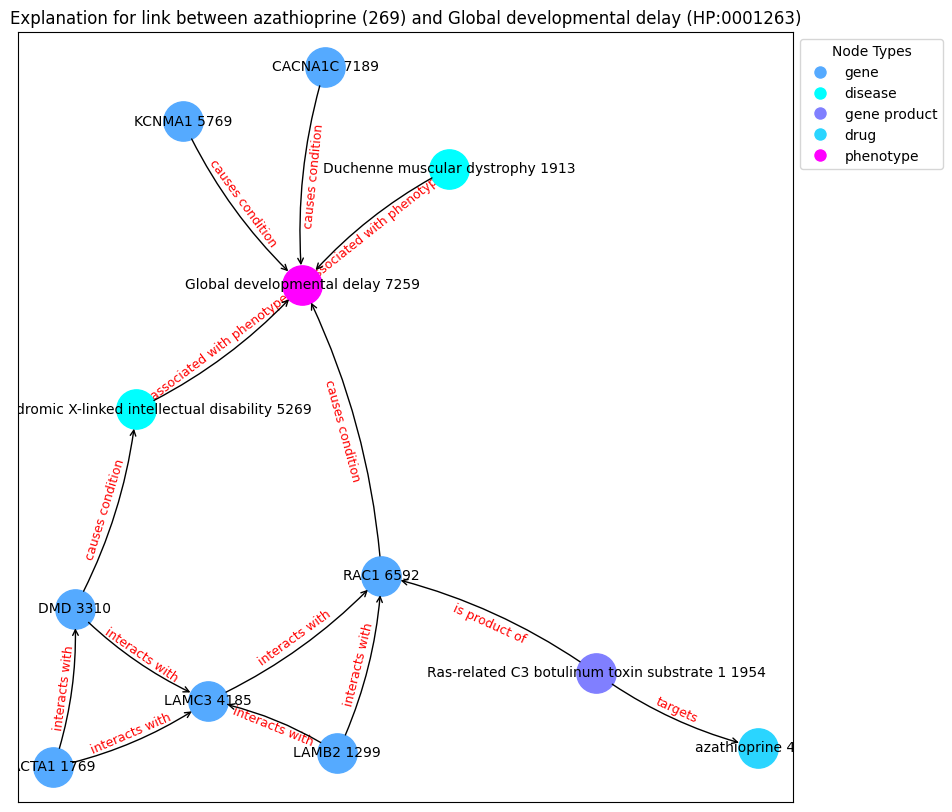

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between levosimendan (1576) and Flexion contracture (HP:0001371)
   Node Type Percentage  Appearances
0       gene     66.67%            8
1  phenotype     16.67%            2
2    disease      8.33%            1
3       drug      8.33%            1
                   Edge Type Percentage  Appearances
0             interacts with     37.50%            6
1           causes condition     37.50%            6
2  associated with phenotype     12.50%            2
3   is substance that treats      6.25%            1
4   contributes to condition      6.25%            1
                                          Metapath Percentage  Appearances
0                     (gene, interacts with, gene)     37.50%            6
7              (gene, causes condition, phenotype)     25.00%            4
1              (phenotype, causes condition, gene)      6.25%            1
2  (phenotype, associated with phenotype, disease)      6.25%            1
3      (phenotype, is substance that

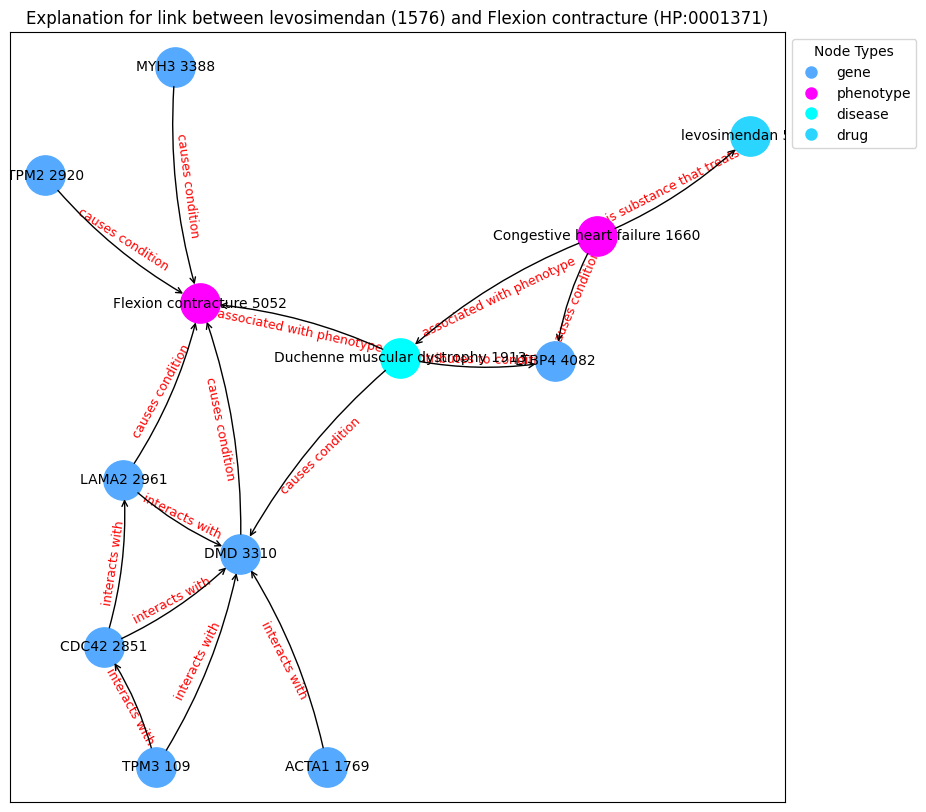

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between levosimendan (1576) and Proximal muscle weakness (HP:0003701)
   Node Type Percentage  Appearances
0       gene     78.57%           11
1  phenotype     14.29%            2
2       drug      7.14%            1
                  Edge Type Percentage  Appearances
0            interacts with     60.00%            9
1          causes condition     33.33%            5
2  is substance that treats      6.67%            1
                                      Metapath Percentage  Appearances
0                 (gene, interacts with, gene)     60.00%            9
1          (phenotype, causes condition, gene)     20.00%            3
3          (gene, causes condition, phenotype)     13.33%            2
2  (phenotype, is substance that treats, drug)      6.67%            1


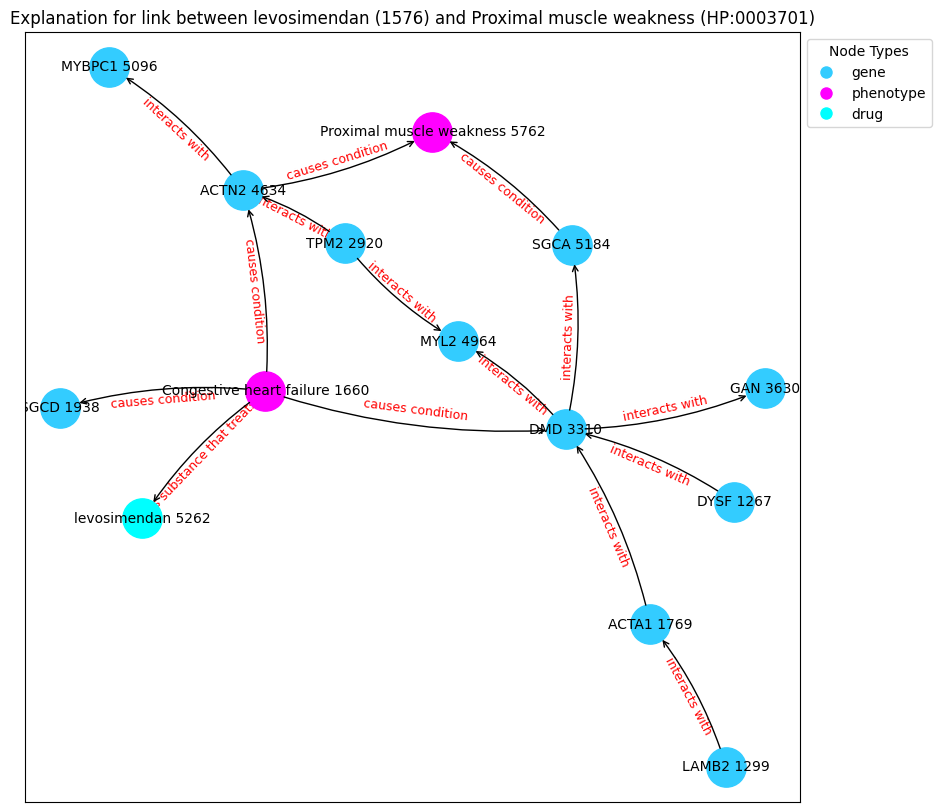

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between levosimendan (1576) and Calf muscle hypertrophy (HP:0008981)
   Node Type Percentage  Appearances
0       gene     69.23%            9
1  phenotype     15.38%            2
2    disease      7.69%            1
3       drug      7.69%            1
                   Edge Type Percentage  Appearances
1           causes condition     50.00%            8
0             interacts with     31.25%            5
2  associated with phenotype      6.25%            1
3   is substance that treats      6.25%            1
4   contributes to condition      6.25%            1
                                          Metapath Percentage  Appearances
1              (gene, causes condition, phenotype)     43.75%            7
0                     (gene, interacts with, gene)     31.25%            5
2              (phenotype, causes condition, gene)      6.25%            1
3  (phenotype, associated with phenotype, disease)      6.25%            1
4      (phenotype, is substance 

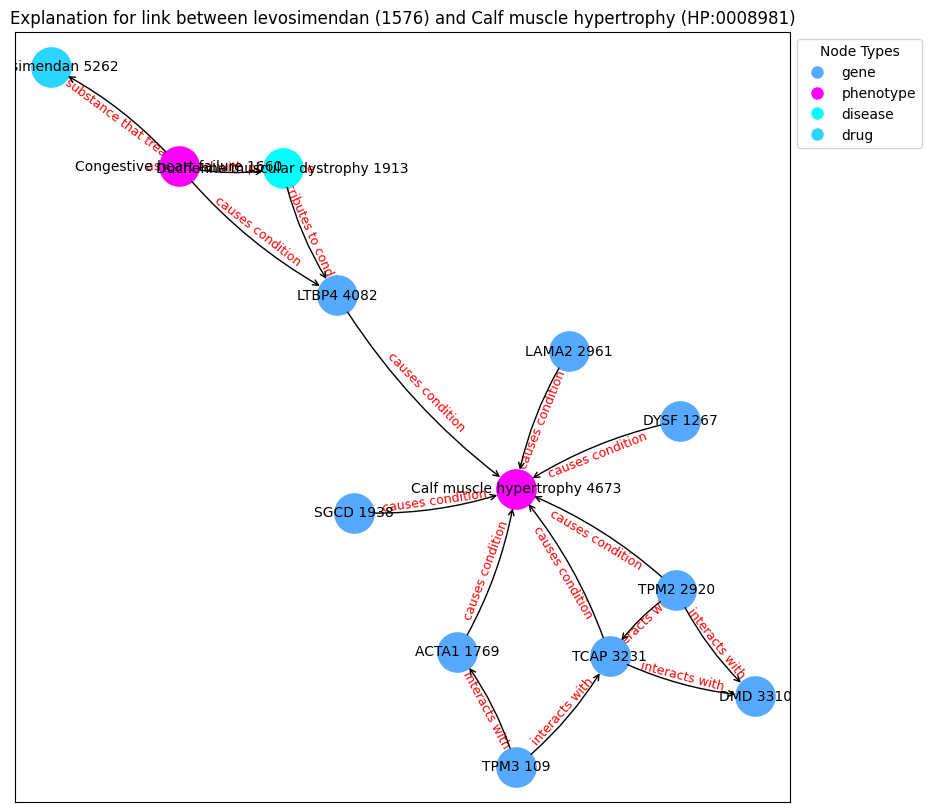

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between levosimendan (1576) and Progressive muscle weakness (HP:0003323)
   Node Type Percentage  Appearances
2       gene     50.00%            8
0    variant     12.50%            2
1  phenotype     12.50%            2
5   genotype     12.50%            2
3    disease      6.25%            1
4       drug      6.25%            1
                   Edge Type Percentage  Appearances
1           causes condition     50.00%            8
5             interacts with     18.75%            3
0              is variant in     12.50%            2
2  associated with phenotype      6.25%            1
3   is substance that treats      6.25%            1
4       has role in modeling      6.25%            1
                                          Metapath Percentage  Appearances
4              (gene, causes condition, phenotype)     31.25%            5
6                     (gene, interacts with, gene)     18.75%            3
0               (variant, is variant in, genotype) 

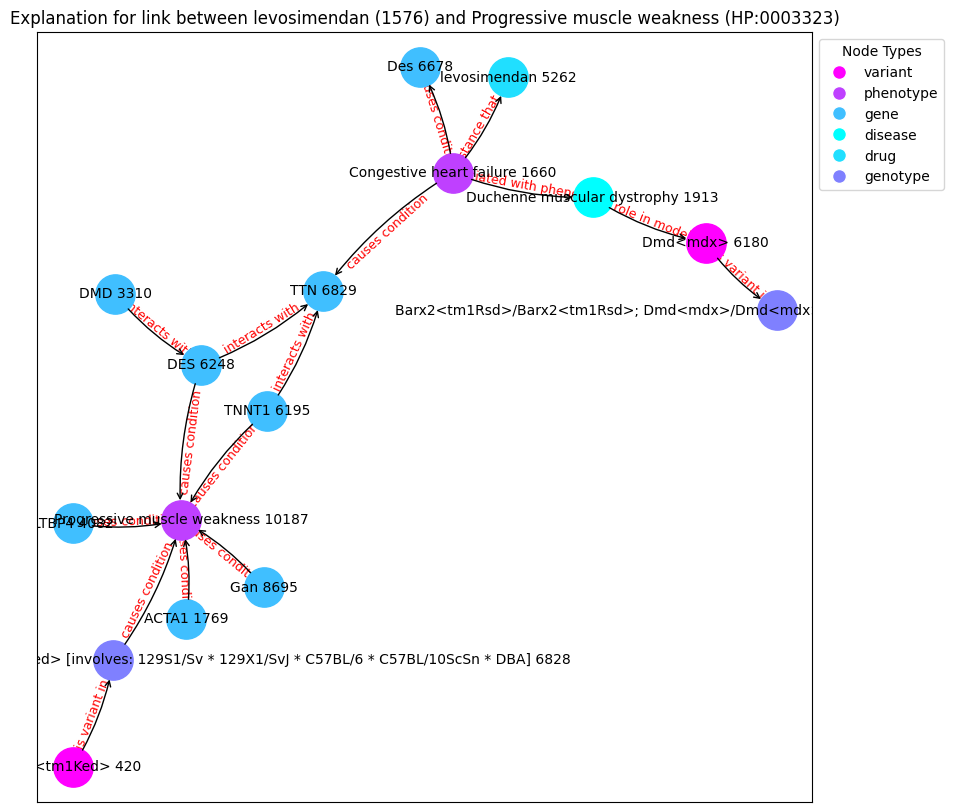

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between carvedilol (522) and Progressive muscle weakness (HP:0003323)
   Node Type Percentage  Appearances
3       gene     46.67%            7
0    variant     13.33%            2
1  phenotype     13.33%            2
5   genotype     13.33%            2
2    disease      6.67%            1
4       drug      6.67%            1
                   Edge Type Percentage  Appearances
0           causes condition     56.25%            9
5             interacts with     12.50%            2
1  associated with phenotype      6.25%            1
2   is substance that treats      6.25%            1
3   contributes to condition      6.25%            1
4       has role in modeling      6.25%            1
6              is variant in      6.25%            1
                                          Metapath Percentage  Appearances
1              (phenotype, causes condition, gene)     18.75%            3
8              (gene, causes condition, phenotype)     18.75%            3
0

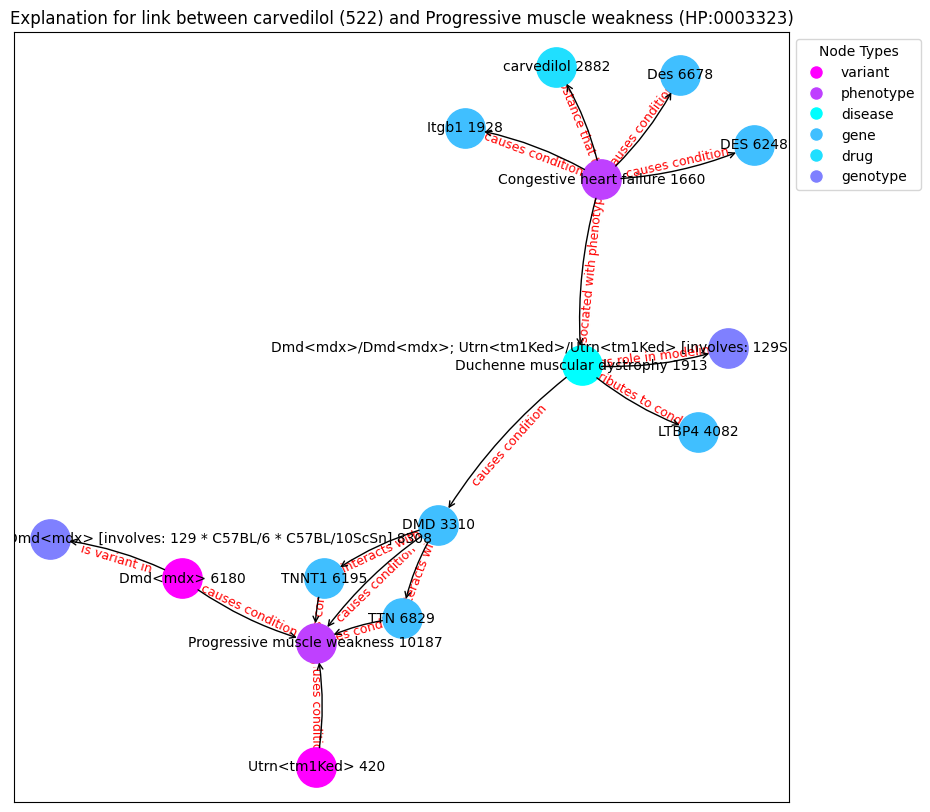

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between levosimendan (1576) and Arrhythmia (HP:0011675)
   Node Type Percentage  Appearances
1       gene     58.33%            7
0  phenotype     16.67%            2
3       drug     16.67%            2
2    disease      8.33%            1
                   Edge Type Percentage  Appearances
0           causes condition     43.75%            7
3             interacts with     31.25%            5
1  associated with phenotype     12.50%            2
2   is substance that treats     12.50%            2
                                          Metapath Percentage  Appearances
3                     (gene, interacts with, gene)     31.25%            5
4              (gene, causes condition, phenotype)     31.25%            5
0              (phenotype, causes condition, gene)     12.50%            2
1  (phenotype, associated with phenotype, disease)      6.25%            1
2      (phenotype, is substance that treats, drug)      6.25%            1
5  (disease, associated

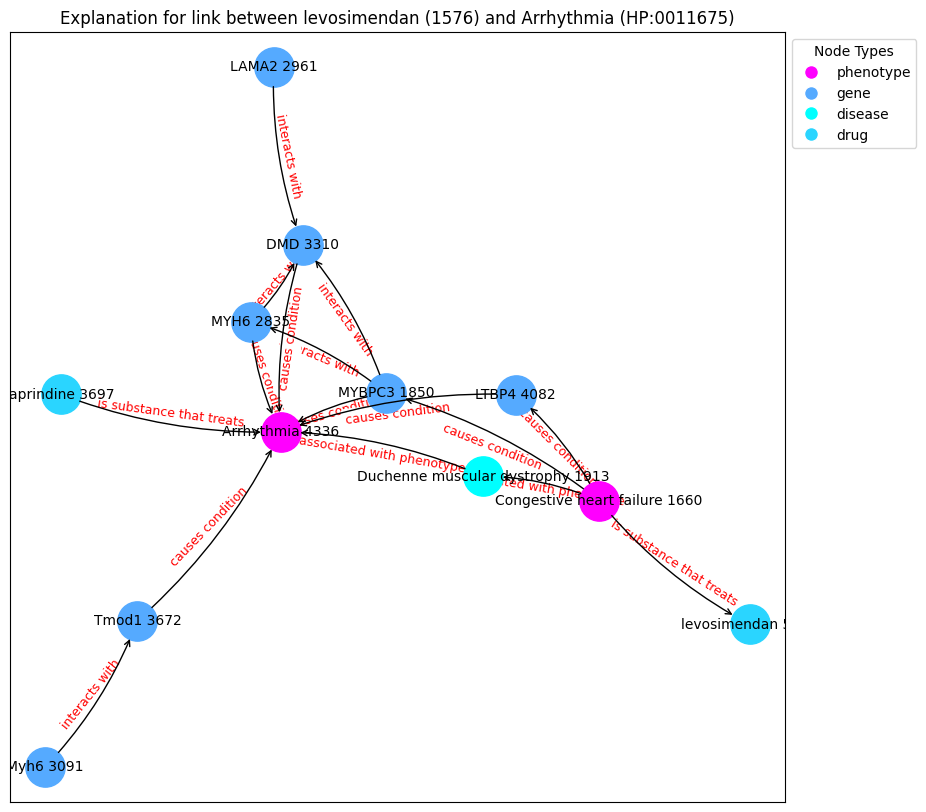

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between aprindine (231) and Arrhythmia (HP:0011675)
   Node Type Percentage  Appearances
0       gene     72.73%            8
1    disease      9.09%            1
2       drug      9.09%            1
3  phenotype      9.09%            1
                        Edge Type Percentage  Appearances
0                causes condition     43.75%            7
1                  interacts with     31.25%            5
2        contributes to condition      6.25%            1
3       associated with phenotype      6.25%            1
4  in orthology relationship with      6.25%            1
5        is substance that treats      6.25%            1
                                          Metapath Percentage  Appearances
0              (gene, causes condition, phenotype)     37.50%            6
1                     (gene, interacts with, gene)     31.25%            5
2                (disease, causes condition, gene)      6.25%            1
3        (disease, contributes to co

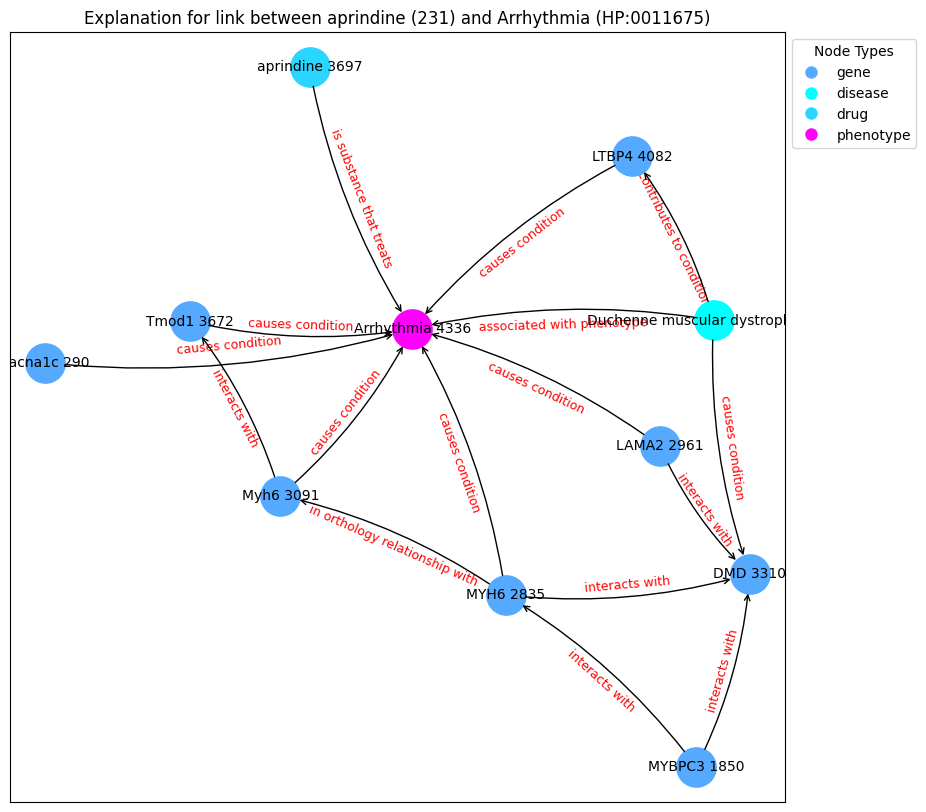

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between carvedilol (522) and Arrhythmia (HP:0011675)
   Node Type Percentage  Appearances
0       gene     61.54%            8
1  phenotype     15.38%            2
3       drug     15.38%            2
2    disease      7.69%            1
                        Edge Type Percentage  Appearances
0                causes condition     43.75%            7
3                  interacts with     25.00%            4
2        is substance that treats     12.50%            2
1       associated with phenotype      6.25%            1
4        contributes to condition      6.25%            1
5  in orthology relationship with      6.25%            1
                                          Metapath Percentage  Appearances
0              (gene, causes condition, phenotype)     25.00%            4
4                     (gene, interacts with, gene)     25.00%            4
1              (phenotype, causes condition, gene)     18.75%            3
2  (phenotype, associated with phen

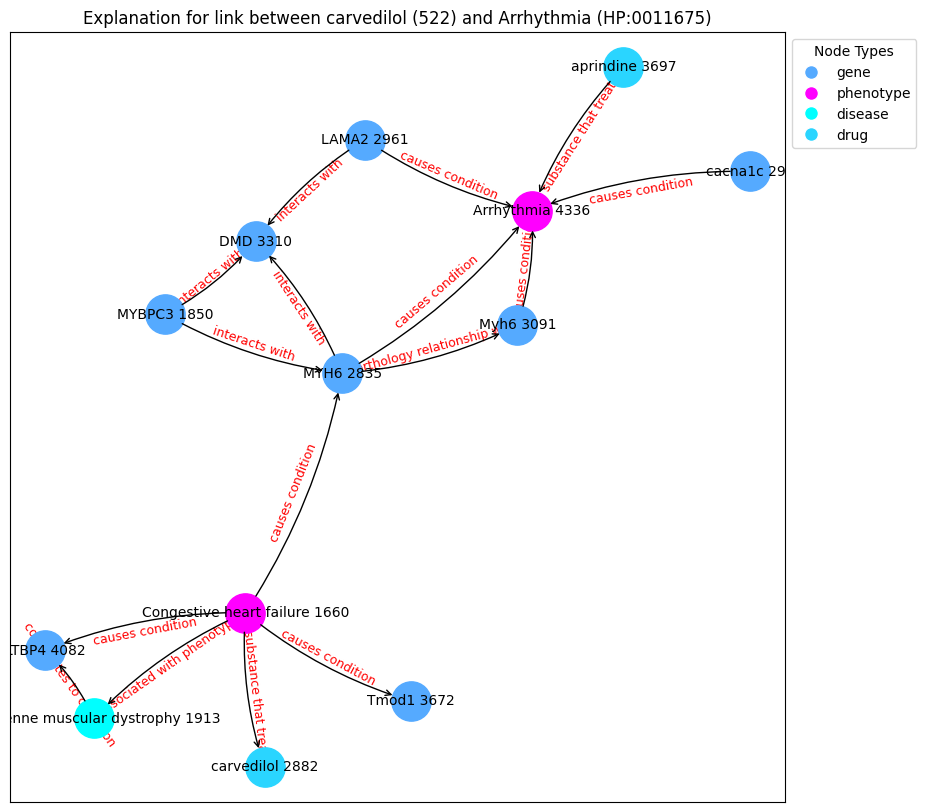

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between panobinostat (4682) and Cognitive impairment (HP:0100543)
   Node Type Percentage  Appearances
1       gene     66.67%            8
2  phenotype     16.67%            2
0    disease      8.33%            1
3       drug      8.33%            1
                   Edge Type Percentage  Appearances
0           causes condition     43.75%            7
3             interacts with     37.50%            6
1   contributes to condition      6.25%            1
2  associated with phenotype      6.25%            1
4   is substance that treats      6.25%            1
                                          Metapath Percentage  Appearances
3              (gene, causes condition, phenotype)     37.50%            6
4                     (gene, interacts with, gene)     37.50%            6
0                (disease, causes condition, gene)      6.25%            1
1        (disease, contributes to condition, gene)      6.25%            1
2  (disease, associated with phenot

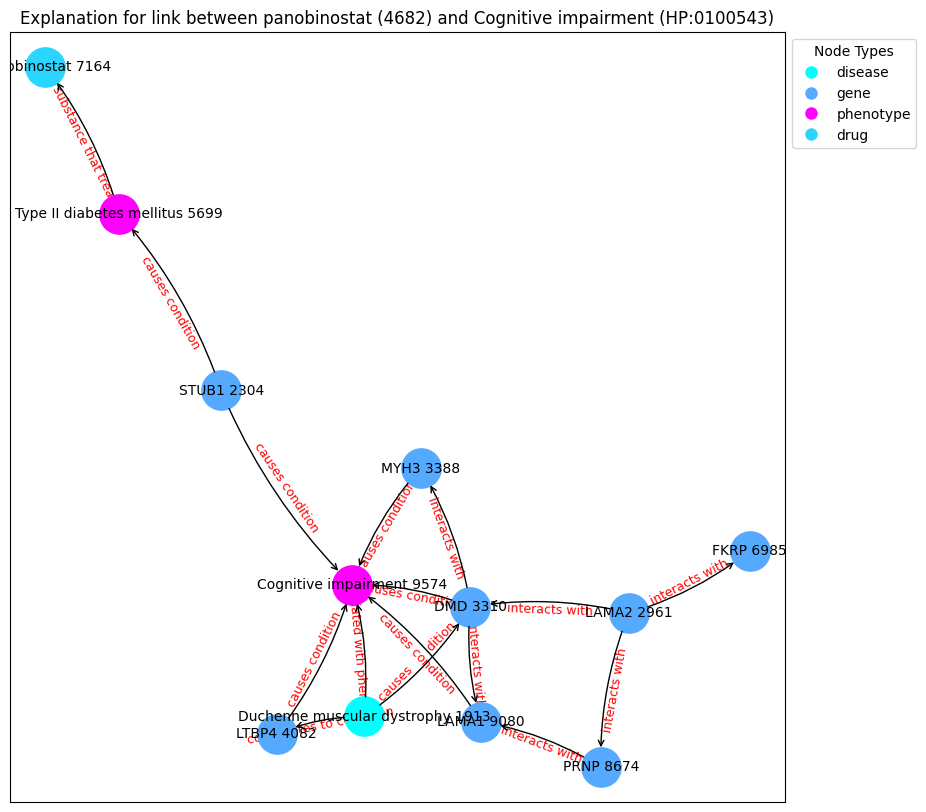

In [21]:
explanations_stats = {}

for i, explanation in enumerate(found_explanation):
    nodes_idxs = torch.Tensor([explanation['node_idx1'], explanation['node_idx2']]).long()
    
    drug_id = explanation['drug']
    drug_name = nodes.loc[nodes['id'] == drug_id]['label'].iloc[0]
    
    symptom_id = explanation['symptom']
    symptom_name = nodes.loc[nodes['id'] == symptom_id]['label'].iloc[0]
    
    explanation_title = f"Explanation for link between {drug_name} ({drug_id}) and {symptom_name} ({symptom_id})"

    plt.figure(figsize=(10, 10))
    plt.title(explanation_title)
    ax, G_sub = visualize_subgraph(nodes_idxs, edge_index, explanation['found_edge_mask'], nodes = nodes, node_labels_dict=node_labels_dict, y=torch.Tensor(nodes.semantic_id), seed = 667, num_hops = num_hops, threshold=explanation['found_limit'], node_label='label', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)

    explanations_stats[i] = count_occurrences(G_sub)
    
    plt.savefig(f'output/g{dataset_nr}_{embedding_method}/explanations/explanation_{i}', bbox_inches='tight')
    plt.show()
    
    # TODO: save images into folder
    # TODO: save graphs 
    # TODO: save statistics